
# Writing multiple netCDF files in parallel with xarray and dask

A typical computation workflow with xarray consists of:

1. reading one or more netCDF files into an xarray dataset backed by dask using `xr.open_mfdataset()` or `xr.open_dataset(chunks=...)`,
2. applying some transformation to the input dataset, and
3. saving the resulting output to disk in a netCDF file using `xr.to_netcdf()`.


The last step (3) can easily lead to a large netCDF file (>=10GB in size). As a result, this step can take a very long time to complete (since it is run in serial), and sometimes may hang. So, to avoid these issues one can use one of the lesser-used but helpful xarray capabilities: the [`xr.save_mfdataset()`](https://xarray.pydata.org/en/latest/generated/xarray.save_mfdataset.html) function. This function allows users to write multiple datasets to disk as netCDF files simultaneously. The `xr.save_mfdataset()` function signature looks like this:

```python
xr.save_mfdataset(
    datasets,
    paths,
    mode='w',
    format=None,
    groups=None,
    engine=None,
    compute=True,
)
Docstring:
Write multiple datasets to disk as netCDF files simultaneously.
```


## Please show me the code

### Package imports

In [1]:
import numpy as np
import xarray as xr
from distributed import Client, performance_report

xr.__version__

'0.15.1'

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:65328 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


### Load some toy dataset

In [3]:
ds = xr.tutorial.open_dataset('rasm', chunks={'time': 12})
ds

<xarray.Dataset>
Dimensions:  (time: 36, x: 275, y: 205)
Coordinates:
  * time     (time) object 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    xc       (y, x) float64 dask.array<chunksize=(205, 275), meta=np.ndarray>
    yc       (y, x) float64 dask.array<chunksize=(205, 275), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    Tair     (time, y, x) float64 dask.array<chunksize=(12, 205, 275), meta=np.ndarray>
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       "4.6.0"
    history:                   Tue Dec 27 14:15:22 2016: ncatted -a dimension...

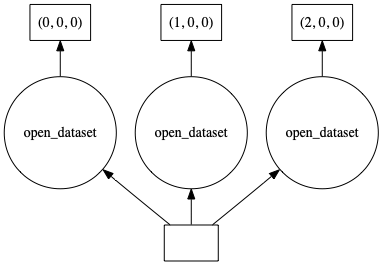

In [4]:
ds.Tair.data.visualize()

### Perform a computation on input dataset

As you can see, our input dataset is chunked along the `time` dimension. This produces an xarray dataset with 3 chunks. For illustrative purposes, let's apply some arbitray computation on our dataset:

In [5]:
result = np.sqrt(np.sin(ds) ** 2 + np.cos(ds) ** 2)

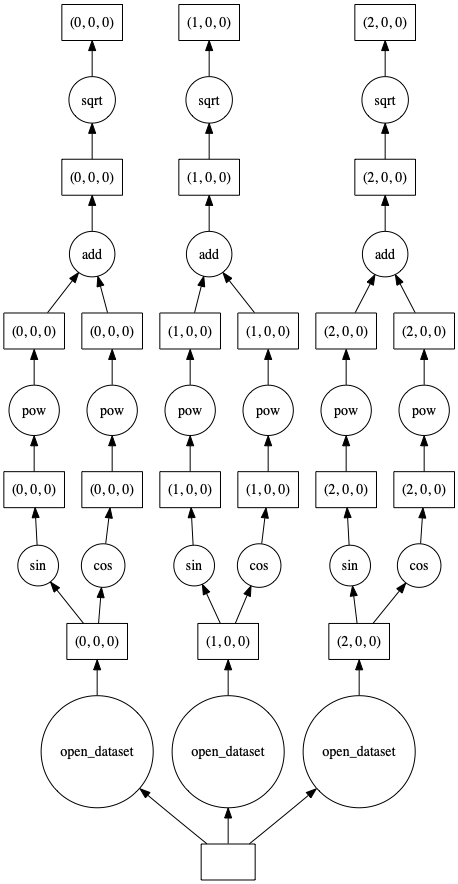

In [6]:
result.Tair.data.visualize()

Our resulting xarray dataset has the same dimensions and the same number of chunks as our input dataset.

### Create a helper function to split a dataset into sub-datasets

Our main objective is to save this resulting dataset into multiple netCDF files by saving each chunk in its own netCDF file. To accomplish this, we need to create a function that allows us to split a dataset into sub-datasets for each chunk. The following code snippet was adapted from this [comment](https://github.com/pydata/xarray/issues/1093#issuecomment-259213382) by [Stephan Hoyer](https://github.com/shoyer).

In [7]:
import itertools


def split_by_chunks(dataset):
    chunk_slices = {}
    for dim, chunks in dataset.chunks.items():
        slices = []
        start = 0
        for chunk in chunks:
            if start >= dataset.sizes[dim]:
                break
            stop = start + chunk
            slices.append(slice(start, stop))
            start = stop
        chunk_slices[dim] = slices
    for slices in itertools.product(*chunk_slices.values()):
        selection = dict(zip(chunk_slices.keys(), slices))
        yield dataset[selection]

In [8]:
datasets = list(split_by_chunks(result))

Let's confirm that we have three items corresponding to our three chunks:

In [9]:
print(len(datasets))

3


Each item in the returned list consists of an xarray dataset corresponding to each sliced chunk. Now that we have a list of datasets, we need another helper function that will generate a filepath for us when given an xarray dataset as input:

### Create a helper function for generating a filepath

In [10]:
def create_filepath(ds, prefix='filename', root_path="."):
    """
    Generate a filepath when given an xarray dataset
    """
    start = ds.time.data[0].strftime("%Y-%m-%d")
    end = ds.time.data[-1].strftime("%Y-%m-%d")
    filepath = f'{root_path}/{prefix}_{start}_{end}.nc'
    return filepath

Let's run a small test to make sure this function is working as expected:

In [11]:
create_filepath(datasets[1])

'./filename_1981-09-16_1982-08-17.nc'

Let's create a list of paths to which to save each corresponding dataset.

In [12]:
paths = [create_filepath(ds) for ds in datasets]
paths

['./filename_1980-09-16_1981-08-17.nc',
 './filename_1981-09-16_1982-08-17.nc',
 './filename_1982-09-16_1983-08-17.nc']

### Invoke `xr.save_mfdataset()`

At this point we have two lists:
    
1. `datasets`: List of datasets to save.
2. `paths`: List of paths to which to save each corresponding dataset.


We are ready to invoke the `xr.save_mfdataset()`:

In [13]:
xr.save_mfdataset(datasets=datasets, paths=paths)

### Confirm that the output files were properly written

In [14]:
new_ds = xr.open_mfdataset(paths, combine='by_coords')
new_ds

<xarray.Dataset>
Dimensions:  (time: 36, x: 275, y: 205)
Coordinates:
    xc       (y, x) float64 dask.array<chunksize=(205, 275), meta=np.ndarray>
    yc       (y, x) float64 dask.array<chunksize=(205, 275), meta=np.ndarray>
  * time     (time) object 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
Dimensions without coordinates: x, y
Data variables:
    Tair     (time, y, x) float64 dask.array<chunksize=(12, 205, 275), meta=np.ndarray>

In [15]:
try:
    xr.testing.assert_identical(result, new_ds)
except AssertionError:
    print('The datasets are not identical!')
else:
    print('The datasets are identical!')

The datasets are identical!


There you have it 🎉🎉🎉🎉

## Conclusion

This article was inspired by a problem that my colleague was running into. I thought it would be useful to document this fix in a blog post. Many thanks to [Deepak Cherian](https://github.com/dcherian) for pointing me to some relevant xarray issues and to the [@NCAR/xdev](https://github.com/orgs/NCAR/teams/xdev) team for their valuable and critical feedback on drafts of this article along the way.